# Hypothesis Testing

Lukas Graz  
February 13, 2025

In [ ]:
source("R/data_prep.R")


Number of matches per filter criteria (not disjoint)
  Headphone  PRS_all_NA    Distance Activity_NA    Duration  HMNoise_NA 
        303         226         221         102          96          96 
JourneyTime 
         20 
Keep  1494 of 2206 observations

Imputing PRS_orig_vars

## Linear Modeling

### Imputation with MissForest on Training Data

In [ ]:
sapply(D[Mediator_vars], \(x) sum(is.na(x)))


 FEELNAT   LNOISE LOC_SENS LOC_SOUN LOC_SCEN LOC_VISE LOC_VEGE LOC_FAUN 
      16      291       28       30       36       62       69       88 

  LCARTIF_sqrt  LCFOREST_sqrt          HETER    OVDIST_sqrt     VIS5K_sqrt 
             0              0              0              0              0 
       RL_NDVI       RL_NOISE    DISTKM_sqrt   JNYTIME_sqrt STRIMP123_sqrt 
             0              0              0             86              0 
STRIMP999_sqrt 
             0 

In [ ]:
# Mediator imputation
D_trn[Mediator_vars] <- xfun::cache_rds({
  missForest(as.matrix(D_trn[Mediator_vars]))
  }, 
  file = "Mediator_imputation.rds", 
  dir = "cache/",
  hash = list(as.matrix(D_trn[Mediator_vars]))
)$ximp |> as.data.frame()

# GIS imputation (missForest)
D_trn[GIS_vars] <- xfun::cache_rds({
  missForest(as.matrix(D_trn[GIS_vars]))
  }, 
  file = "GIS_imputation.rds", 
  dir = "cache/",
  hash = list(as.matrix(D_trn[GIS_vars]))
)$ximp |> as.data.frame()


### Remove “LOC\_” variables from Mediators

In [ ]:
Mediator_vars <- grep("LOC_", Mediator_vars, invert = TRUE, value = TRUE)


### Scaling Test Data

In [ ]:
all_vars <- c(Mediator_vars, GIS_vars, PRS_vars)
old_scale <- t(sapply(D_tst[c(all_vars)], \(x) 
  c(mean = mean(x, na.rm = TRUE), sd = sd(x, na.rm = TRUE))))

D_tst[c(all_vars)] <- lapply(D_tst[c(all_vars)], scale)
D_trn_scaled <- D_trn
D_trn_scaled[c(all_vars)] <- lapply(D_trn[c(all_vars)], scale)

old_scale


                 mean     sd
FEELNAT         6.142  1.055
LNOISE          4.210  0.747
LCARTIF_sqrt    0.271  0.269
LCFOREST_sqrt   0.454  0.311
HETER           1.305  0.402
OVDIST_sqrt    21.797 10.144
VIS5K_sqrt      3.323  1.620
RL_NDVI         0.635  0.202
RL_NOISE       41.615  9.261
DISTKM_sqrt     1.473  1.156
JNYTIME_sqrt    3.830  2.247
STRIMP123_sqrt  6.555 10.739
STRIMP999_sqrt 47.557 13.162
MEAN            4.987  0.882
FA              5.266  1.111
BA              5.141  1.157
EC              4.542  1.290
ES              5.006  1.430

### Testing VIF

In [ ]:
car::vif(fit_PRS_MED <- lm(as.formula(paste0(
  PRS_vars[1], 
  " ~ ", 
  paste(Mediator_vars, collapse = " + "), " + ",
  paste(GIS_vars,      collapse = " + ")
)), D_trn)) |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.16    1.37    1.93    2.07    2.31    4.94 

In [ ]:
suppressMessages(
car::vif(fit_PRS_MED <- lm(as.formula(paste0(
  PRS_vars[1], 
  " ~ ", 
  "(", paste(Mediator_vars, collapse = " + "), 
     " + ", paste(GIS_vars, collapse = " + "), 
  ")^2"
)), D_trn))) |> summary()


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.46   37.91  103.11  152.87  214.68  928.44 

Since we model *with* interactions later, the latter VIF are relevant for us. Given that they are very high (c.f. median and max), we would have no hope of finding any significant results in the full interaction model. Therefore, we will first perfom a variable selection, to reduce the VIF and enable us to find significant effects.

### All Interactions: Mediators ~ (GIS)^2

In [ ]:

# Elegant function to create coefficient tables from model summaries
library(dplyr)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

In [ ]:
Res3 <- list()
for (mediator in Mediator_vars) {
  intercept_model <- lm(as.formula(paste0(
    mediator, " ~ 1")), D_trn)
  step_model <- step(intercept_model, 
    scope = as.formula(paste0(
      mediator, " ~ ", 
      "(", paste(GIS_vars, collapse = " + "), ")^2"
    )),
    trace = FALSE, k = log(nrow(D_trn))
  )
  Res3[[mediator]] <- lm(formula(step_model), D_tst)
}
(ResSum3 <- lapply(Res3, summary))


$FEELNAT

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-4.959 -0.391  0.264  0.607  1.685 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.0618     0.0410    1.51  0.13260    
LCARTIF_sqrt          -0.1524     0.0570   -2.67  0.00770 ** 
RL_NDVI                0.1498     0.0436    3.43  0.00063 ***
OVDIST_sqrt            0.0270     0.0452    0.60  0.55112    
LCARTIF_sqrt:RL_NDVI   0.1146     0.0402    2.85  0.00446 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.948 on 733 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.106, Adjusted R-squared:  0.101 
F-statistic: 21.8 on 4 and 733 DF,  p-value: <2e-16


$LNOISE

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.999 -0.527  0.012  0.676  1.622 

Coefficients:
             Estimate 

#### Visualization of Interactioneffect of LCARTIF_sqrt \* RL_NDVI

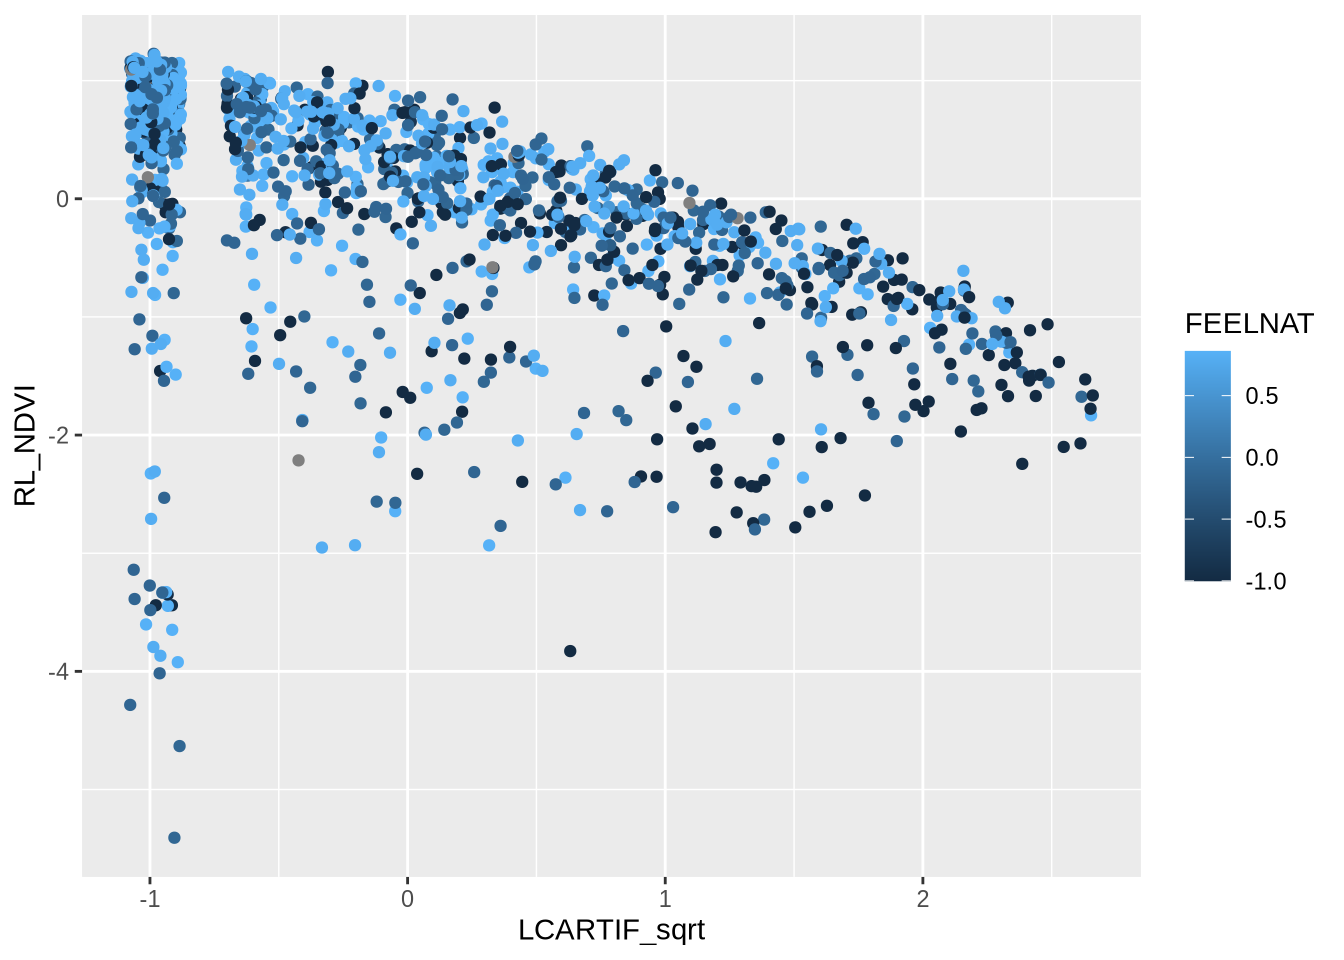

Warning in geom_point(width = 0.07, alpha = 0.6): Ignoring unknown parameters:
`width`

`geom_smooth()` using formula = 'y ~ x'

(`stat_smooth()`).

(`geom_point()`).

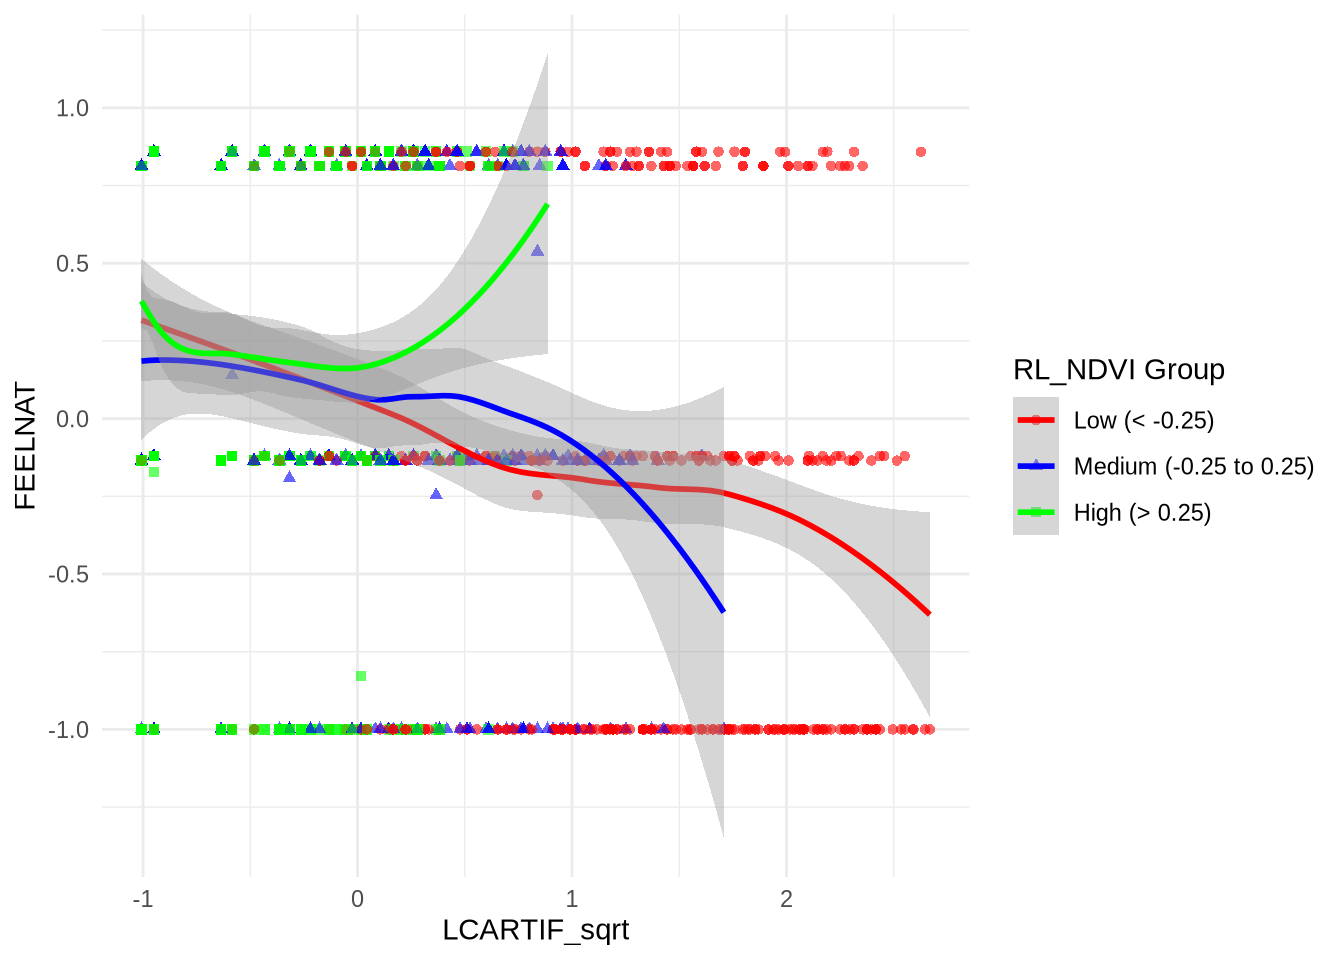

In [ ]:

library(ggplot2)
D_plot <- rbind(D_trn_scaled, D_tst)
D_plot$FEELNAT <- pmax(-1,pmin(1,D_plot$FEELNAT))
ggplot(D_plot, aes(x = LCARTIF_sqrt, y=RL_NDVI, col = FEELNAT)) +
  geom_jitter(width=0.07)


### All Interactions: PRS ~ (Mediators + GIS)^2

In [ ]:
Res4 <- list()
for (prs in PRS_vars) {
  intercept_model <- lm(as.formula(paste0(
    prs, " ~ 1")), D_trn)
  step_model <- step(intercept_model, 
    scope = as.formula(paste0(
      prs, " ~ ", 
      "(", paste(GIS_vars, collapse = " + "), " + ", 
      paste(Mediator_vars, collapse = " + "), ")^2"
    )),
    trace = FALSE, k = log(nrow(D_trn))
  )
  Res4[[prs]] <- lm(formula(step_model), D_tst)
}
(ResSum4 <- lapply(Res4, summary))


$MEAN

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.201 -0.589 -0.018  0.566  2.392 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.00623    0.04014   -0.16    0.877    
FEELNAT         0.25068    0.04538    5.52  5.0e-08 ***
LNOISE          0.21276    0.04180    5.09  4.8e-07 ***
LCFOREST_sqrt  -0.06571    0.03899   -1.69    0.093 .  
DISTKM_sqrt    -0.01861    0.03877   -0.48    0.631    
FEELNAT:LNOISE  0.02216    0.03320    0.67    0.505    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.925 on 586 degrees of freedom
  (155 observations deleted due to missingness)
Multiple R-squared:  0.136, Adjusted R-squared:  0.128 
F-statistic: 18.4 on 5 and 586 DF,  p-value: <2e-16


$FA

Call:
lm(formula = formula(step_model), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.799 -0.580  0.032  0.634  2.263 

Coefficients:
       

### Table Summarizing Coefficients

Significant codes as usual: `0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1`

#### All Interactions: Mediators ~ (GIS)^2

In [ ]:
ResTab3 <- create_coef_table(ResSum3)
saveRDS(ResTab3, "cache/ResSum3.rds")
ResTab3


  Covariate                 FEELNAT        LNOISE
  ---------------------- ------------- --------------
  (Intercept)                0.062         -0.001
  LCARTIF_sqrt            -0.152\*\*      -0.124\*
  LCARTIF_sqrt:RL_NDVI     0.115\*\*   
  OVDIST_sqrt                0.027     
  RL_NDVI                 0.150\*\*\*  
  RL_NOISE                              -0.242\*\*\*


#### PRS ~ (Mediators + GIS)^2

In [ ]:
ResTab4 <- create_coef_table(ResSum4)
saveRDS(ResTab4, "cache/ResSum4.rds")
ResTab4


  Covariate            MEAN           FA            BA            EC           ES
  ---------------- ------------- ------------- ------------- ------------ -------------
  (Intercept)         -0.006         0.005        -0.008        -0.006        0.028
  DISTKM_sqrt         -0.019                                                 0.073.
  FEELNAT           0.251\*\*\*   0.265\*\*\*   0.252\*\*\*     0.058      0.269\*\*\*
  FEELNAT:LNOISE       0.022        -0.036                                
  LCFOREST_sqrt       -0.066.                                 -0.113\*\*  
  LNOISE            0.213\*\*\*   0.171\*\*\*                               0.142\*\*
  LNOISE:FEELNAT                                                             -0.012
  RL_NDVI                         -0.105\*\*                              
